# Install

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 20.4MB/s 


# Evn

In [ ]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [ ]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [ ]:
!nvidia-smi

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir
data_dir = '/content/drive/MyDrive/data/data'
os.listdir(data_dir)

['ko_32000.model',
 'ko_32000.vocab',
 'kowiki',
 'mycorpus',
 '.ipynb_checkpoints',
 'my_vocab.model',
 'nsmc']

In [ ]:
# nsmc dir
nsmc_dir = os.path.join(data_dir, 'nsmc')
if not os.path.exists(nsmc_dir):
    os.makedirs(nsmc_dir)
os.listdir(nsmc_dir)

['ratings_train.txt', 'ratings_test.txt', 'stub.csv', 'stub.hdf5']

# Vocabulary & config

In [ ]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [ ]:
n_vocab = len(vocab)  # number of vocabulary
n_seq = 47  # number of sequence
d_model = 256  # dimension of model
n_out = 2  # number of output class

# 모델링

In [ ]:
def build_model(n_vocab, d_model, n_seq, n_out):
    """
    문장의 감정분류 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장길이 (단어 수)
    :param n_out: 예측할 class 개수
    """
    inputs = tf.keras.layers.Input((n_seq,))  # (bs, n_seq)
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden = embedding(inputs)  # (bs, n_seq, d_model)
    ######################
    conv_1 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='causal')
    hidden = conv_1(hidden)
    ######################
    # 각 단어 벡터의 최대값 기준으로 벡터를 더해서 차원을 줄여줌 (문장 vector 생성)
    pool = tf.keras.layers.GlobalMaxPool1D()
    hidden_pool = pool(hidden)  # (bs, d_model)
    # 문장 vector를 이용해서 긍정(1), 부정(0) 확률값 예측
    linear = tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    outputs = linear(hidden_pool)  # (bs, n_out)
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# All Data Project

## Data


In [ ]:
# train data load
df_train = pd.read_csv(os.path.join(nsmc_dir, 'ratings_train.txt'), delimiter='\t')
df_train

In [ ]:
# train null 데이터 제거
df_train = df_train.dropna()
df_train

In [ ]:
# train data load
df_test = pd.read_csv(os.path.join(nsmc_dir, 'ratings_test.txt'), delimiter='\t')
df_test

In [ ]:
# train null 데이터 제거
df_test = df_test.dropna()
df_test

In [ ]:
def load_data(df, n_seq):
    """
    NSMC 학습 데이터 생성
    :param df: data frame
    :param n_seq: number of sequence
    :return inputs: input data
    :return labels: label data
    """
    inputs = np.zeros((len(df), n_seq)).astype(np.int32)
    labels = np.zeros((len(df),))
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        # print()
        label = row['label']
        document = row['document']
        # print(label, document)
        tokens = vocab.encode_as_pieces(document)
        # print(len(tokens), ':', tokens)
        token_ids = vocab.encode_as_ids(document)
        # print(len(token_ids), ':', token_ids)
        token_ids = token_ids[:n_seq]
        # print(len(token_ids), ':', token_ids)
        token_ids += [0] * (n_seq - len(token_ids))
        # print(len(token_ids), ':', token_ids)

        labels[index] = label
        inputs[index] = token_ids
        index += 1
    return inputs, labels

In [ ]:
# train data 생성
train_inputs, train_labels = load_data(df_train, n_seq)
train_inputs, train_labels

(array([[  188, 16337,     7, ...,     0,     0,     0],
        [15825,     7,     7, ...,     0,     0,     0],
        [ 2329,   349,     1, ...,     0,     0,     0],
        ...,
        [   29,   128, 19999, ...,     0,     0,     0],
        [14943,  7071,   802, ...,     0,     0,     0],
        [  253,   321,  1071, ...,     0,     0,     0]], dtype=int32),
 array([0., 1., 0., ..., 0., 1., 0.]))

In [ ]:
# test data 생성
test_inputs, test_labels = load_data(df_test, n_seq)
test_inputs, test_labels

(array([[ 5441,    10, 31026, ...,     0,     0,     0],
        [  618,   509,   798, ...,     0,     0,     0],
        [19999,   173,    29, ...,     0,     0,     0],
        ...,
        [ 2087,    32, 22687, ...,     0,     0,     0],
        [ 3991, 27855,    11, ...,     0,     0,     0],
        [ 4404,    11,   375, ...,     0,     0,     0]], dtype=int32),
 array([1., 0., 0., ..., 0., 0., 0.]))

## 학습

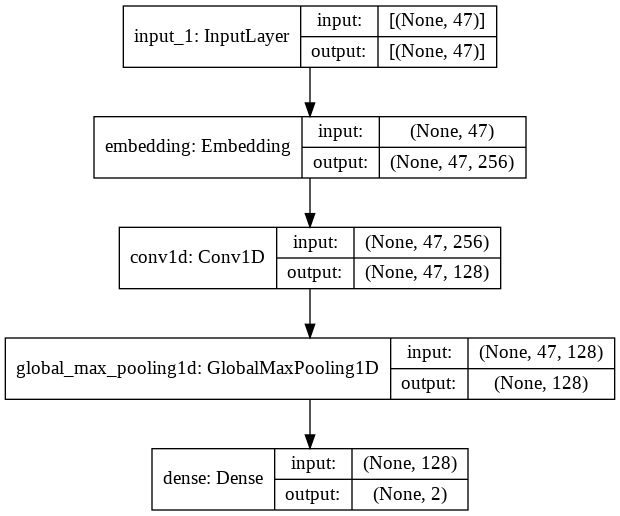

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq, n_out)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(nsmc_dir, 'stub.hdf5'),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(nsmc_dir, 'stub.csv'))

In [ ]:
# 모델 학습
history = model.fit(train_inputs,
                    train_labels,
                    validation_data=(test_inputs, test_labels),
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
586/586 [==============================] - 59s 88ms/step - loss: 0.4556 - accuracy: 0.7873 - val_loss: 0.3386 - val_accuracy: 0.8528

Epoch 00001: val_accuracy improved from -inf to 0.85277, saving model to /content/drive/MyDrive/data/data/nsmc/stub.hdf5
Epoch 2/100
586/586 [==============================] - 50s 86ms/step - loss: 0.2640 - accuracy: 0.8953 - val_loss: 0.3279 - val_accuracy: 0.8597

Epoch 00002: val_accuracy improved from 0.85277 to 0.85965, saving model to /content/drive/MyDrive/data/data/nsmc/stub.hdf5
Epoch 3/100
586/586 [==============================] - 50s 85ms/step - loss: 0.1716 - accuracy: 0.9390 - val_loss: 0.3474 - val_accuracy: 0.8597

Epoch 00003: val_accuracy did not improve from 0.85965
Epoch 4/100
586/586 [==============================] - 50s 86ms/step - loss: 0.0994 - accuracy: 0.9705 - val_loss: 0.3958 - val_accuracy: 0.8547

Epoch 00004: val_accuracy did not improve from 0.85965
Epoch 5/100
586/586 [==============================] - 50s 85

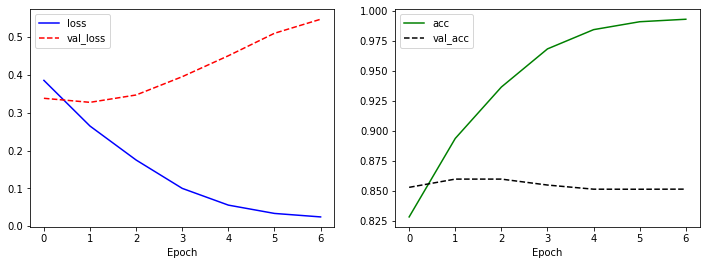

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='acc')
plt.plot(history.history['val_accuracy'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [ ]:
# 모델 생성
model = build_model(n_vocab, d_model, n_seq, n_out)
# train weight로 초기화
model.load_weights(os.path.join(nsmc_dir, 'stub.hdf5'))

In [ ]:
# 예측
logits = model.predict(test_inputs)
logits

array([[0.02333861, 0.9766614 ],
       [0.43648508, 0.5635149 ],
       [0.07358594, 0.9264141 ],
       ...,
       [0.02148787, 0.9785121 ],
       [0.99796605, 0.00203396],
       [0.52290785, 0.47709212]], dtype=float32)

In [ ]:
# 확률 최대 값을 예측으로 사용
test_preds = np.argmax(logits, axis=-1)
test_preds

array([1, 1, 1, ..., 1, 0, 0])

In [ ]:
confusion_matrix = np.zeros((n_out, n_out)).astype(np.int)
for y_true, y_pred in zip(test_labels, test_preds):
    confusion_matrix[int(y_true), int(y_pred)] += 1
confusion_matrix

array([[21094,  3732],
       [ 3285, 21886]])

In [ ]:
tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

accuracy: 0.8596515790947457
precision: 0.8543211804200171
recall: 0.869492670136268
f1: 0.861840162239855


In [ ]:
def do_predict(model, n_seq, string):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param n_seq: 입력 개수
    :param string: 입력 문자열
    """
    # token 생성: <string tokens>, [PAD] tokens
    token = vocab.encode_as_ids(string)[:n_seq]
    token += [0] * (n_seq - len(token))
    token = token[:n_seq]

    y_pred = model.predict(np.array([token]))
    y_pred_class = K.argmax(y_pred, axis=-1)

    return "긍정" if y_pred_class[0] == 1 else "부정"

In [ ]:
while True:
    print("input > ", end="")
    string = str(input())
    if len(string) == 0:
        break
    print(f"output > {do_predict(model, n_seq, string)}")

input > 정말 좋은걸까요?
output > 긍정
input > 다른사람한테 추천하고 싶지 않아요
output > 부정
input > 1111
output > 긍정
input > 좆나 재미 없다
output > 부정
input > 겁나게 재미있지는 않다
output > 부정
input > 
